## TimeSHAP

Used on Aachen dataset

In [5]:
import timeshap

import numpy as np
import pandas as pd
import tensorflow as tf

# Import the dataset preprocessing function
from Load_and_Preprocess_Aachen import preprocess_aachen_dataset

# TensorFlow/Keras imports
from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.layers import LSTM, Dense, Dropout, Masking, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import matplotlib.pyplot as plt

In [6]:
# Configurable parameters
def get_config():
    """Return a dictionary of configurable parameters."""
    return {
        "learning_rate": 0.001,
        "clipnorm": 1.0,
        "lstm_units": 32,
        "dense_units": 16,
        "dropout_rate": 0.2,
        "epochs": 30,
        "batch_size": 32,
        "patience": 10  # For EarlyStopping
    }


def build_model(input_shape, config):
    """Build and compile the LSTM model."""
    model = Sequential([
        Input(shape=input_shape),
        Masking(mask_value=0.0),
        LSTM(config["lstm_units"], activation='tanh', recurrent_activation='sigmoid', return_sequences=False, unroll=False),
        Dropout(config["dropout_rate"]),
        Dense(config["dense_units"], activation='tanh'),
        Dense(1)  # Output layer for regression
    ])
    optimizer = Adam(learning_rate=config["learning_rate"], clipnorm=config["clipnorm"])
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model


def plot_training_history(history):
    """Plot the training and validation loss over epochs."""
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss', marker='o')
    plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
    plt.title("Training and Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid()
    plt.show()

In [7]:
# Load configuration
config = get_config()

# Load and preprocess the Aachen dataset
aachen_data = preprocess_aachen_dataset(
    "/Users/sigurdgjerdingen/Student/Master kode/Master_Herstad-Gjerdingen/Aachen/Degradation_Prediction_Dataset_ISEA.mat",
    test_cell_count=3,
    random_state=42,
    phase="Mid",
    log_transform=False,
)

# Extract the preprocessed data
X_train_lstm = aachen_data["X_train"]
X_val_lstm = aachen_data["X_val"]
X_test_lstm = aachen_data["X_test"]
y_train = aachen_data["y_train"]
y_val = aachen_data["y_val"]
y_test = aachen_data["y_test"]
y_max = aachen_data["y_max"]

# Build the model
model = build_model(X_train_lstm.shape[1:], config)

# Define callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=config["patience"], restore_best_weights=True)
]

# Train the model
history = model.fit(
    X_train_lstm, y_train,
    validation_data=(X_val_lstm, y_val),
    epochs=config["epochs"],
    batch_size=config["batch_size"],
    verbose=1,
    callbacks=callbacks
)

Epoch 1/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - loss: 0.0367 - mae: 0.1325 - val_loss: 0.0041 - val_mae: 0.0493
Epoch 2/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - loss: 0.0062 - mae: 0.0590 - val_loss: 0.0041 - val_mae: 0.0496
Epoch 3/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - loss: 0.0059 - mae: 0.0575 - val_loss: 0.0044 - val_mae: 0.0520
Epoch 4/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - loss: 0.0055 - mae: 0.0558 - val_loss: 0.0053 - val_mae: 0.0520
Epoch 5/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - loss: 0.0054 - mae: 0.0554 - val_loss: 0.0040 - val_mae: 0.0491
Epoch 6/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - loss: 0.0052 - mae: 0.0546 - val_loss: 0.0041 - val_mae: 0.0499
Epoch 7/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - loss: 0.0050 - mae: 0.0540 - val_loss: 0.0043 - val_mae: 0.0478
Epoch 8/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - loss: 0.0049 - mae: 0.0533 - val_loss: 0.0042 - val_mae: 0.0476
Epoch 9/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/

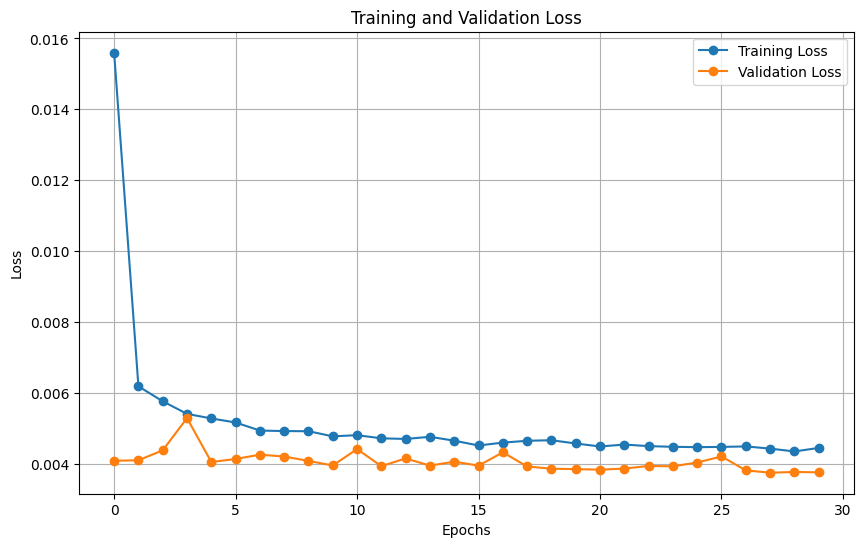

In [8]:
# Plot training history
plot_training_history(history)

In [9]:
# Evaluate the model on the test set
test_loss, test_mae = model.evaluate(X_test_lstm, y_test, verbose=1)
print(f"\nTest Loss: {test_loss}")
print(f"Test MAE: {test_mae}")

# Make predictions on the test set
y_pred = model.predict(X_test_lstm)

# Rescale predictions and test data back to the original range
y_pred_rescaled = y_pred.flatten() * y_max
y_test_rescaled = y_test * y_max

# Compare actual and predicted values
results = pd.DataFrame({
    "Actual RUL80": y_test_rescaled,
    "Predicted RUL80": y_pred_rescaled
})
print(results.head())

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6.1655e-04 - mae: 0.0210

Test Loss: 0.0009215252939611673
Test MAE: 0.024539822712540627
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
   Actual RUL80  Predicted RUL80
0        1060.0      1000.434326
1        1055.0       994.956848
2        1050.0       990.565674
3        1045.0       986.953552
4        1040.0       983.854980


## Timeshap

In [10]:
# Model entry point 

f = lambda x: model.predict(x)

In [11]:
average_event = X_train_lstm[X_train_lstm != 0].mean()

# dataframe with the average event
average_event_df = pd.DataFrame(average_event.reshape(1, -1))

average_event_df


,0
0,0.67301


In [12]:
# Select a random row from LSTM training data with shape (7190, 272, 1) to be (1, 272, 1) while printing the selected row
random_sequence_number = np.random.randint(X_train_lstm.shape[0])

random_sequence = X_train_lstm[random_sequence_number][np.newaxis, :, :]
random_sequence_number


3839

In [15]:
# Select a random row from LSTM training data with shape (7190, 272, 1) to be (1, 272, 1) while printing the selected row
test_random_sequence_number = np.random.randint(X_test_lstm.shape[0])

test_random_sequence = X_test_lstm[test_random_sequence_number][np.newaxis, :, :]
test_random_sequence_number


102

In [16]:
from timeshap.explainer import local_report

# 1) Define pruning settings (optional)
pruning_dict = {
    'tol': 0.025
}

# 2) Define settings for event-level explanations
event_dict = {
    'rs': 42,            # random seed
    'nsamples': 32000    # number of coalitions to sample
}

# 3) Define settings for feature-level explanations
feature_dict = {
    'rs': 42,
    'nsamples': 32000,
    'feature_names': [0],          # The single feature is index 0
    'plot_features': {0: 'RUL'}    # A label to display in plots (renames feature 0 -> "RUL")
}

## 4) Define settings for cell-level explanations
#cell_dict = {
#    'rs': 42,
#    'nsamples': 32000,
#    'top_x_feats': 1,    # Only 1 feature total
#    'top_x_events': 1    # For example, show top 1 event
#}

# 5) Call local_report
plot = local_report(
    f=f,                      # Your model inference function, shape (n, seq_len, n_features) -> (n, 1)
    data=test_random_sequence,          # A single 3D array, shape = (1, seq_len, 1) or a DataFrame with one row
    pruning_dict=pruning_dict,
    event_dict=event_dict,
    feature_dict=feature_dict,   
    entity_uuid=[0],          # If you need an identifier; otherwise can be None
    entity_col=0,             # Or None if you're passing a plain np.array with no entity column
    baseline=average_event_df 
)

Assuming all features are model features
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━

In [17]:
plot

the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.


alt.HConcatChart(...)

In [18]:
# Pruning algorithm
from timeshap.explainer import local_pruning
from timeshap.plot import plot_temp_coalition_pruning

pruning_dict = {'tol': 0,}
coal_plot_data, coal_prun_idx = local_pruning(f, test_random_sequence, pruning_dict, average_event_df, test_random_sequence_number, [0], False)
# coal_prun_idx is in negative terms
pruning_idx = random_sequence.shape[1] + coal_prun_idx
pruning_plot = plot_temp_coalition_pruning(coal_plot_data, coal_prun_idx, plot_limit=300)
pruning_plot

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━

the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.


alt.LayerChart(...)

In [19]:
pruning_idx

0

In [20]:
# Event-level explanations
from timeshap.explainer import local_event
from timeshap.plot import plot_event_heatmap

event_dict = {'rs': 42, 'nsamples': 32000}
event_data = local_event(f, 
                         random_sequence, 
                         event_dict, 
                         random_sequence_number, 
                         entity_col = 0,
                         baseline=average_event_df,
                         pruned_idx=250) # set manually
event_plot = plot_event_heatmap(event_data)
event_plot

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step


the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.


alt.LayerChart(...)

## Global plots

In [78]:
# Draw 10 random samples from the test set (numpy.ndarray)
random_samples = X_test_lstm[np.random.choice(X_test_lstm.shape[0], 3, replace=False)]
random_samples.shape

random_samples_df = pd.DataFrame(random_samples.reshape(random_samples.shape[0], random_samples.shape[1]))

# make a list shema of the index of samples in strings
schema = [str(col) for col in random_samples_df.columns]



In [81]:
from timeshap.explainer import global_report

pruning_dict = {
    'rs': 42,                # Provide a random seed
    'tol': [0.05, 0.075],
    'path': 'outputs/prun_all_tf.csv'
}
event_dict = {'path': 'outputs/event_all_tf.csv', 'rs': 42, 'nsamples': 500}
feature_dict = {
    'rs': 42,
    'nsamples': 5,
    'feature_names': None,          # The single feature is index 0
    'plot_features': {0: 'RUL'}    # A label to display in plots (renames feature 0 -> "RUL")
}

prun_stats, global_plot = global_report(f, random_samples_df, pruning_dict, event_dict, feature_dict, average_event_df, model_features=[0], schema=schema, entity_col=1, time_col=None)

prun_stats

No path to persist feature explanations provided.
Calculating pruning algorithm
No time col provided, assuming dataset is ordered ascendingly by date
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Calculating event data
No time col provided, assuming dataset is ordered ascendingly by date
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/s

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Calculating pruning indexes


AssertionError: 

In [32]:
global_plot

NameError: name 'global_plot' is not defined

In [ ]:
# Convert my X_train_lstm numpy.ndarray to a pandas DataFrame

X_train_lstm_df = pd.DataFrame(X_train_lstm.reshape(X_train_lstm.shape[0], X_train_lstm.shape[1]))
schema = list(X_train_lstm_df.columns)
X_train_lstm_df

# Refer to the index columns of the dataframe?   
#Set index to name id 
X_train_lstm_df.index.name = 'id'

sequence_id = 'id'
X_train_lstm_df

In [ ]:
from timeshap.explainer import prune_all, pruning_statistics

pruning_dict = {'tol': 0.025}
prun_index = prune_all(f, 
                       X_train_lstm, 
                       pruning_dict, 
                       average_event_df,
                       model_features = [0],
                       schema= schema,
                       entity_col = sequence_id,
                       time_col = 0, 
                       verbose=False)


In [ ]:
from timeshap.explainer import event_explain_all
from timeshap.plot import plot_global_event

# Define the missing variables
sequence_id_feat = 0  # Example value, replace with the actual value
time_feat = 0  # Example value, replace with the actual value

event_dict = {'rs': 42, 'nsamples': 32000}
event_data = event_explain_all(f, X_train_lstm, event_dict, prun_indexes, average_event_df, model_features=[0], schema=schema, sequence_id_feat=sequence_id_feat, time_feat=time_feat)
event_global_plot = plot_global_event(event_data)
event_global_plot